### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU # دروب اوت يقلل الاوفر فيتنق
from keras.optimizers import SGD #ياخذ بوينت باي بوينت
import math
from sklearn.metrics import mean_squared_error

## Helper Functions for Plotting Predictions and Calculating RMSE

In [15]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [16]:
dataset = pd.read_csv('/content/3220083b-750c-4a30-9f94-213f3a7a073f.tmp', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [17]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

Visualizing the data

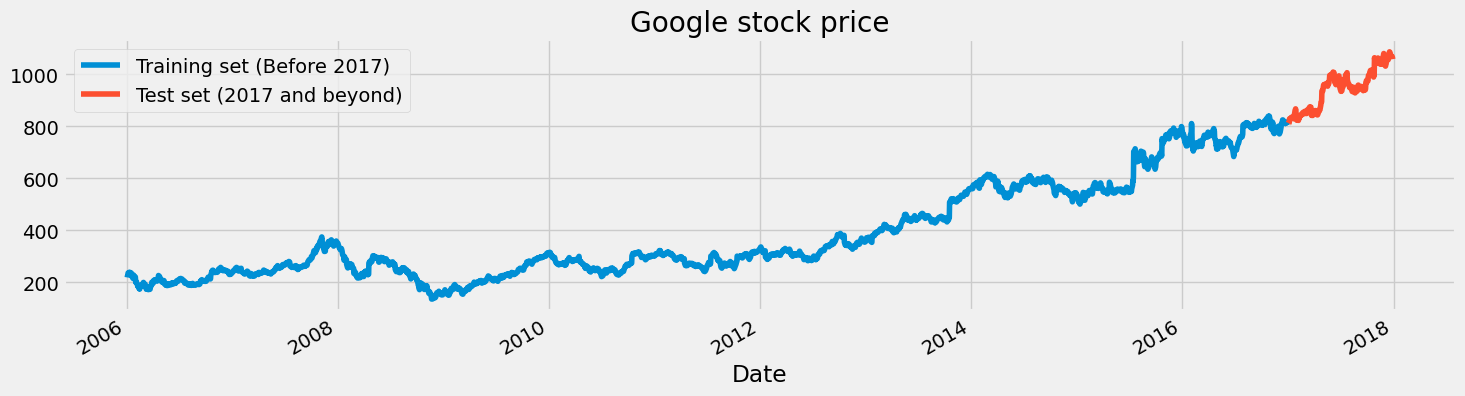

In [18]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [8]:
X_train = []
y_train = []
for i in range(60,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

Reshaping X_train for efficient modelling

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## LSTM Model

In [11]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))


regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))


regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - loss: 0.0314
Epoch 2/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0068
Epoch 3/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 0.0057
Epoch 4/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0050
Epoch 5/5
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0040



## Make preductuion with LSTM model

In [12]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [14]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step


Visualizing the results

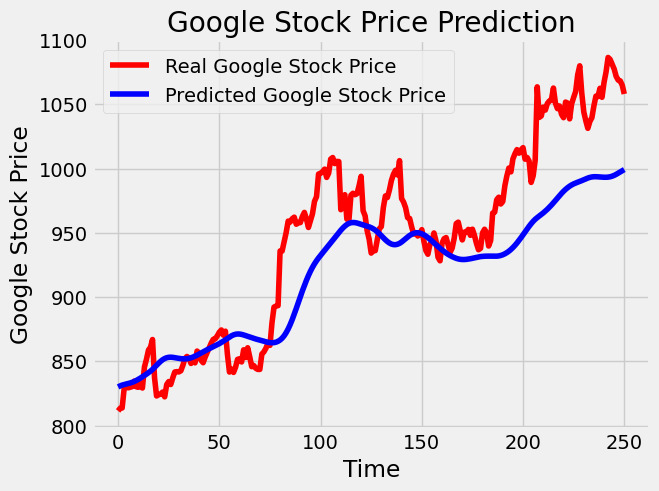

In [19]:
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [20]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 43.176818076760995.


## GRU Model

In [21]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

regressorGRU.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - loss: 0.1234
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - loss: 0.0495
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - loss: 0.0153
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 0.0038
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - loss: 0.0035



## Make preductuion with GRU model

In [22]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


Visualizing the Results

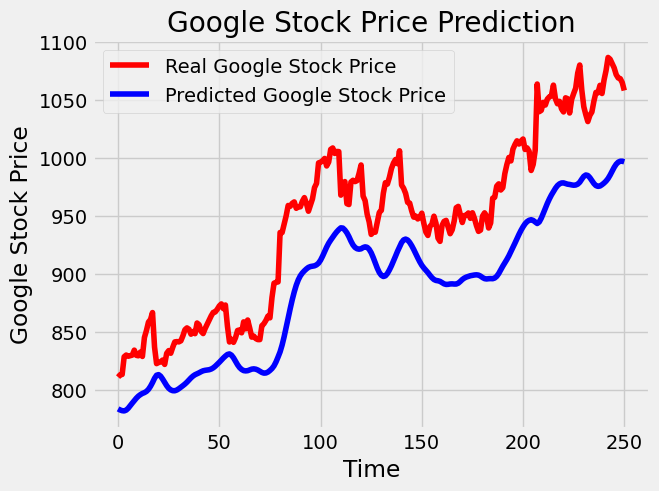

In [23]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [24]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 59.878828569310514.
